<a href="https://colab.research.google.com/github/Ajmyquira/Real-time-semantic-segmentation/blob/main/01_Fast_SCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget --keep-session-cookies --save-cookies=cookies.txt --post-data "username=Ajmyquira&password=Gr34Aw.@f5o&submit=Login" https://www.cityscapes-dataset.com/login/

--2021-11-22 14:29:43--  https://www.cityscapes-dataset.com/login/
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cityscapes-dataset.com/downloads/ [following]
--2021-11-22 14:29:43--  https://www.cityscapes-dataset.com/downloads/
Reusing existing connection to www.cityscapes-dataset.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘index.html’

index.html              [ <=>                ]  47.36K  --.-KB/s    in 0.03s   

2021-11-22 14:29:44 (1.44 MB/s) - ‘index.html’ saved [48495]



In [ ]:
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3

--2021-11-22 14:12:22--  https://www.cityscapes-dataset.com/file-handling/?packageID=3
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11592327197 (11G) [application/octet-stream]
Saving to: ‘leftImg8bit_trainvaltest.zip’

leftImg8bit_trainva 100%[===================>]  10.80G  24.3MB/s    in 7m 30s  

2021-11-22 14:19:54 (24.5 MB/s) - ‘leftImg8bit_trainvaltest.zip’ saved [11592327197/11592327197]



In [ ]:
!unzip leftImg8bit_trainvaltest.zip -d /content/drive/MyDrive/Colab_Notebooks/data

In [ ]:
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1

--2021-11-22 14:29:55--  https://www.cityscapes-dataset.com/file-handling/?packageID=1
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252567705 (241M) [application/octet-stream]
Saving to: ‘gtFine_trainvaltest.zip’

gtFine_trainvaltest 100%[===================>] 240.87M   105MB/s    in 2.3s    

2021-11-22 14:29:57 (105 MB/s) - ‘gtFine_trainvaltest.zip’ saved [252567705/252567705]



In [ ]:
!unzip gtFine_trainvaltest.zip -d /content/drive/MyDrive/Colab_Notebooks/data

# Testing the data

In [ ]:
from torchvision import transforms

input_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
        ])

data_kwargs = {'transform': input_transform, 'base_size': 1024, 'crop_size': 768}

train_dataset = get_segmentation_dataset('citys', split='train', mode='train', **data_kwargs)
val_dataset = get_segmentation_dataset('citys', split='val', mode='val', **data_kwargs)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=10, shuffle=True, drop_last=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=10, shuffle=False)

Found 2975 images in the folder /content/drive/MyDrive/Colab_Notebooks/data/leftImg8bit/train
Found 500 images in the folder /content/drive/MyDrive/Colab_Notebooks/data/leftImg8bit/val


In [ ]:
for data in train_loader:
  print(data)
  break

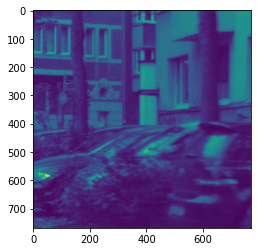

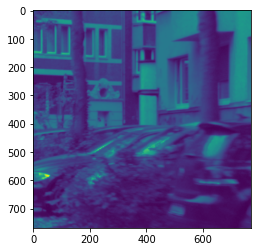

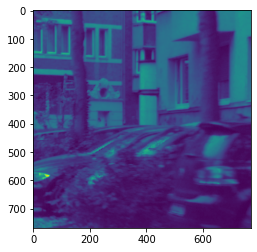

tensor([[ 8,  8,  8,  ...,  2,  2,  2],
        [ 8,  8,  8,  ...,  2,  2,  2],
        [ 8,  8,  8,  ...,  2,  2,  2],
        ...,
        [-1, -1, -1,  ..., 13, 13, 13],
        [-1, -1, -1,  ..., 13, 13, 13],
        [-1, -1, -1,  ..., 13, 13, 13]])


In [ ]:
import matplotlib.pyplot as plt

# imagen
plt.imshow(data[0][0][2].view(768, 768))
plt.show()
plt.imshow(data[0][0][1].view(768, 768))
plt.show()
plt.imshow(data[0][0][0].view(768, 768))
plt.show()

# label
y = data[1][0]
print(y)

# Implementation

## Charge the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import os
import random
import math
import argparse
import time
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import threading
import torch.backends.cudnn as cudnn

from PIL import Image, ImageOps, ImageFilter
from __future__ import division
from torch.autograd import Variable
from torchvision import transforms

## Data loader class

In [ ]:
__all__ = ['CitySegmentation']

class CitySegmentation(data.Dataset):
    BASE_DIR = 'cityscapes'
    NUM_CLASS = 19

    def __init__(self, root='/content/drive/MyDrive/Colab_Notebooks/data', split='train', mode=None, transform=None,
                 base_size=520, crop_size=480, **kwargs):
        super(CitySegmentation, self).__init__()
        self.root = root
        self.split = split
        self.mode = mode if mode is not None else split
        self.transform = transform
        self.base_size = base_size
        self.crop_size = crop_size
        self.images, self.mask_paths = _get_city_pairs(self.root, self.split)
        assert (len(self.images) == len(self.mask_paths))
        if len(self.images) == 0:
            raise RuntimeError("Found 0 images in subfolders of: " + self.root + "\n")
        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22,
                              23, 24, 25, 26, 27, 28, 31, 32, 33]
        self._key = np.array([-1, -1, -1, -1, -1, -1,
                              -1, -1, 0, 1, -1, -1,
                              2, 3, 4, -1, -1, -1,
                              5, -1, 6, 7, 8, 9,
                              10, 11, 12, 13, 14, 15,
                              -1, -1, 16, 17, 18])
        self._mapping = np.array(range(-1, len(self._key) - 1)).astype('int32')

    def _class_to_index(self, mask):
        values = np.unique(mask)
        for value in values:
            assert (value in self._mapping)
        index = np.digitize(mask.ravel(), self._mapping, right=True)
        return self._key[index].reshape(mask.shape)

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        if self.mode == 'test':
            if self.transform is not None:
                img = self.transform(img)
            return img, os.path.basename(self.images[index])
        mask = Image.open(self.mask_paths[index])
        # synchrosized transform
        if self.mode == 'train':
            img, mask = self._sync_transform(img, mask)
        elif self.mode == 'val':
            img, mask = self._val_sync_transform(img, mask)
        else:
            assert self.mode == 'testval'
            img, mask = self._img_transform(img), self._mask_transform(mask)
        # general resize, normalize and toTensor
        if self.transform is not None:
            img = self.transform(img)
        return img, mask

    def _val_sync_transform(self, img, mask):
        outsize = self.crop_size
        short_size = outsize
        w, h = img.size
        if w > h:
            oh = short_size
            ow = int(1.0 * w * oh / h)
        else:
            ow = short_size
            oh = int(1.0 * h * ow / w)
        img = img.resize((ow, oh), Image.BILINEAR)
        mask = mask.resize((ow, oh), Image.NEAREST)
        # center crop
        w, h = img.size
        x1 = int(round((w - outsize) / 2.))
        y1 = int(round((h - outsize) / 2.))
        img = img.crop((x1, y1, x1 + outsize, y1 + outsize))
        mask = mask.crop((x1, y1, x1 + outsize, y1 + outsize))
        # final transform
        img, mask = self._img_transform(img), self._mask_transform(mask)
        return img, mask

    def _sync_transform(self, img, mask):
        # random mirror
        if random.random() < 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        crop_size = self.crop_size
        # random scale (short edge)
        short_size = random.randint(int(self.base_size * 0.5), int(self.base_size * 2.0))
        w, h = img.size
        if h > w:
            ow = short_size
            oh = int(1.0 * h * ow / w)
        else:
            oh = short_size
            ow = int(1.0 * w * oh / h)
        img = img.resize((ow, oh), Image.BILINEAR)
        mask = mask.resize((ow, oh), Image.NEAREST)
        # pad crop
        if short_size < crop_size:
            padh = crop_size - oh if oh < crop_size else 0
            padw = crop_size - ow if ow < crop_size else 0
            img = ImageOps.expand(img, border=(0, 0, padw, padh), fill=0)
            mask = ImageOps.expand(mask, border=(0, 0, padw, padh), fill=0)
        # random crop crop_size
        w, h = img.size
        x1 = random.randint(0, w - crop_size)
        y1 = random.randint(0, h - crop_size)
        img = img.crop((x1, y1, x1 + crop_size, y1 + crop_size))
        mask = mask.crop((x1, y1, x1 + crop_size, y1 + crop_size))
        # gaussian blur as in PSP
        if random.random() < 0.5:
            img = img.filter(ImageFilter.GaussianBlur(
                radius=random.random()))
        # final transform
        img, mask = self._img_transform(img), self._mask_transform(mask)
        return img, mask

    def _img_transform(self, img):
        return np.array(img)

    def _mask_transform(self, mask):
        target = self._class_to_index(np.array(mask).astype('int32'))
        return torch.LongTensor(np.array(target).astype('int32'))

    def __len__(self):
        return len(self.images)

    @property
    def num_class(self):
        """Number of categories."""
        return self.NUM_CLASS

    @property
    def pred_offset(self):
        return 0


def _get_city_pairs(folder, split='train'):
    def get_path_pairs(img_folder, mask_folder):
        img_paths = []
        mask_paths = []
        for root, _, files in os.walk(img_folder):
            for filename in files:
                if filename.endswith(".png"):
                    imgpath = os.path.join(root, filename)
                    foldername = os.path.basename(os.path.dirname(imgpath))
                    maskname = filename.replace('leftImg8bit', 'gtFine_labelIds')
                    maskpath = os.path.join(mask_folder, foldername, maskname)
                    if os.path.isfile(imgpath) and os.path.isfile(maskpath):
                        img_paths.append(imgpath)
                        mask_paths.append(maskpath)
                    else:
                        print('cannot find the mask or image:', imgpath, maskpath)
        print('Found {} images in the folder {}'.format(len(img_paths), img_folder))
        return img_paths, mask_paths

    if split in ('train', 'val'):
        img_folder = os.path.join(folder, 'leftImg8bit/' + split)
        mask_folder = os.path.join(folder, 'gtFine/' + split)
        img_paths, mask_paths = get_path_pairs(img_folder, mask_folder)
        return img_paths, mask_paths
    else:
        assert split == 'trainval'
        print('trainval set')
        train_img_folder = os.path.join(folder, 'leftImg8bit/train')
        train_mask_folder = os.path.join(folder, 'gtFine/train')
        val_img_folder = os.path.join(folder, 'leftImg8bit/val')
        val_mask_folder = os.path.join(folder, 'gtFine/val')
        train_img_paths, train_mask_paths = get_path_pairs(train_img_folder, train_mask_folder)
        val_img_paths, val_mask_paths = get_path_pairs(val_img_folder, val_mask_folder)
        img_paths = train_img_paths + val_img_paths
        mask_paths = train_mask_paths + val_mask_paths
    return img_paths, mask_paths

datasets = {
    'citys': CitySegmentation,
}

def get_segmentation_dataset(name, **kwargs):
    """Segmentation Datasets"""
    return datasets[name.lower()](**kwargs)

## Model classes

### Fast_SCNN class

In [ ]:
class FastSCNN(nn.Module):
    def __init__(self, num_classes, aux=False, **kwargs):
        super(FastSCNN, self).__init__()
        self.aux = aux
        self.learning_to_downsample = LearningToDownsample(32, 48, 64)
        self.global_feature_extractor = GlobalFeatureExtractor(64, [64, 96, 128], 128, 6, [3, 3, 3])
        self.feature_fusion = FeatureFusionModule(64, 128, 128)
        self.classifier = Classifer(128, num_classes)
        if self.aux:
            self.auxlayer = nn.Sequential(
                nn.Conv2d(64, 32, 3, padding=1, bias=False),
                nn.BatchNorm2d(32),
                nn.ReLU(True),
                nn.Dropout(0.1),
                nn.Conv2d(32, num_classes, 1)
            )

    def forward(self, x):
        size = x.size()[2:]
        higher_res_features = self.learning_to_downsample(x)
        x = self.global_feature_extractor(higher_res_features)
        x = self.feature_fusion(higher_res_features, x)
        x = self.classifier(x)
        outputs = []
        x = F.interpolate(x, size, mode='bilinear', align_corners=True)
        outputs.append(x)
        if self.aux:
            auxout = self.auxlayer(higher_res_features)
            auxout = F.interpolate(auxout, size, mode='bilinear', align_corners=True)
            outputs.append(auxout)
        return tuple(outputs)

### Operations

In [ ]:
class _ConvBNReLU(nn.Module):
    """Conv-BN-ReLU"""
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, **kwargs):
        super(_ConvBNReLU, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class _DSConv(nn.Module):
    """Depthwise Separable Convolutions"""

    def __init__(self, dw_channels, out_channels, stride=1, **kwargs):
        super(_DSConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(dw_channels, dw_channels, 3, stride, 1, groups=dw_channels, bias=False),
            nn.BatchNorm2d(dw_channels),
            nn.ReLU(True),
            nn.Conv2d(dw_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class _DWConv(nn.Module):
    def __init__(self, dw_channels, out_channels, stride=1, **kwargs):
        super(_DWConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(dw_channels, out_channels, 3, stride, 1, groups=dw_channels, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.conv(x)

### Linear Bottleneck used in MobileNetV2

In [ ]:
class LinearBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, t=6, stride=2, **kwargs):
        super(LinearBottleneck, self).__init__()
        self.use_shortcut = stride == 1 and in_channels == out_channels
        self.block = nn.Sequential(
            # pw
            _ConvBNReLU(in_channels, in_channels * t, 1),
            # dw
            _DWConv(in_channels * t, in_channels * t, stride),
            # pw-linear
            nn.Conv2d(in_channels * t, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = self.block(x)
        if self.use_shortcut:
            out = x + out
        return out

### Pyramid pooling module

In [ ]:
class PyramidPooling(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(PyramidPooling, self).__init__()
        inter_channels = int(in_channels / 4)
        self.conv1 = _ConvBNReLU(in_channels, inter_channels, 1, **kwargs)
        self.conv2 = _ConvBNReLU(in_channels, inter_channels, 1, **kwargs)
        self.conv3 = _ConvBNReLU(in_channels, inter_channels, 1, **kwargs)
        self.conv4 = _ConvBNReLU(in_channels, inter_channels, 1, **kwargs)
        self.out = _ConvBNReLU(in_channels * 2, out_channels, 1)

    def pool(self, x, size):
        avgpool = nn.AdaptiveAvgPool2d(size)
        return avgpool(x)

    def upsample(self, x, size):
        return F.interpolate(x, size, mode='bilinear', align_corners=True)

    def forward(self, x):
        size = x.size()[2:]
        feat1 = self.upsample(self.conv1(self.pool(x, 1)), size)
        feat2 = self.upsample(self.conv2(self.pool(x, 2)), size)
        feat3 = self.upsample(self.conv3(self.pool(x, 3)), size)
        feat4 = self.upsample(self.conv4(self.pool(x, 6)), size)
        x = torch.cat([x, feat1, feat2, feat3, feat4], dim=1)
        x = self.out(x)
        return x

### Learning to downsample module

In [ ]:
class LearningToDownsample(nn.Module):
    def __init__(self, dw_channels1=32, dw_channels2=48, out_channels=64, **kwargs):
        super(LearningToDownsample, self).__init__()
        self.conv = _ConvBNReLU(3, dw_channels1, 3, 2)
        self.dsconv1 = _DSConv(dw_channels1, dw_channels2, 2)
        self.dsconv2 = _DSConv(dw_channels2, out_channels, 2)

    def forward(self, x):
        x = self.conv(x)
        x = self.dsconv1(x)
        x = self.dsconv2(x)
        return x

### Global feature extractor module

In [ ]:
class GlobalFeatureExtractor(nn.Module):
    def __init__(self, in_channels=64, block_channels=(64, 96, 128),
                 out_channels=128, t=6, num_blocks=(3, 3, 3), **kwargs):
        super(GlobalFeatureExtractor, self).__init__()
        self.bottleneck1 = self._make_layer(LinearBottleneck, in_channels, block_channels[0], num_blocks[0], t, 2)
        self.bottleneck2 = self._make_layer(LinearBottleneck, block_channels[0], block_channels[1], num_blocks[1], t, 2)
        self.bottleneck3 = self._make_layer(LinearBottleneck, block_channels[1], block_channels[2], num_blocks[2], t, 1)
        self.ppm = PyramidPooling(block_channels[2], out_channels)

    def _make_layer(self, block, inplanes, planes, blocks, t=6, stride=1):
        layers = []
        layers.append(block(inplanes, planes, t, stride))
        for i in range(1, blocks):
            layers.append(block(planes, planes, t, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.bottleneck1(x)
        x = self.bottleneck2(x)
        x = self.bottleneck3(x)
        x = self.ppm(x)
        return x

### Feature fusion module

In [ ]:
class FeatureFusionModule(nn.Module):
    def __init__(self, highter_in_channels, lower_in_channels, out_channels, scale_factor=4, **kwargs):
        super(FeatureFusionModule, self).__init__()
        self.scale_factor = scale_factor
        self.dwconv = _DWConv(lower_in_channels, out_channels, 1)
        self.conv_lower_res = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels)
        )
        self.conv_higher_res = nn.Sequential(
            nn.Conv2d(highter_in_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU(True)

    def forward(self, higher_res_feature, lower_res_feature):
        lower_res_feature = F.interpolate(lower_res_feature, scale_factor=4, mode='bilinear', align_corners=True)
        lower_res_feature = self.dwconv(lower_res_feature)
        lower_res_feature = self.conv_lower_res(lower_res_feature)

        higher_res_feature = self.conv_higher_res(higher_res_feature)
        out = higher_res_feature + lower_res_feature
        return self.relu(out)

### Classifier

In [ ]:
class Classifer(nn.Module):
    def __init__(self, dw_channels, num_classes, stride=1, **kwargs):
        super(Classifer, self).__init__()
        self.dsconv1 = _DSConv(dw_channels, dw_channels, stride)
        self.dsconv2 = _DSConv(dw_channels, dw_channels, stride)
        self.conv = nn.Sequential(
            nn.Dropout(0.1),
            nn.Conv2d(dw_channels, num_classes, 1)
        )

    def forward(self, x):
        x = self.dsconv1(x)
        x = self.dsconv2(x)
        x = self.conv(x)
        return x

### Get() function

In [ ]:
def get_fast_scnn(dataset='citys', pretrained=False, root='./weights', map_cpu=False, **kwargs):
    model = FastSCNN(19, **kwargs)
    if pretrained:
        if(map_cpu):
            model.load_state_dict(torch.load(os.path.join(root, 'fast_scnn_citys.pth'), map_location='cpu'))
        else:
            model.load_state_dict(torch.load(os.path.join(root, 'fast_scnn_citys.pth')))
    return model


## Metrics class

In [ ]:
class SegmentationMetric(object):
    """Computes pixAcc and mIoU metric scores
    """

    def __init__(self, nclass):
        super(SegmentationMetric, self).__init__()
        self.nclass = nclass
        self.lock = threading.Lock()
        self.reset()

    def update(self, preds, labels):
        """Updates the internal evaluation result.
        Parameters
        ----------
        labels : 'NumpyArray' or list of `NumpyArray`
            The labels of the data.
        preds : 'NumpyArray' or list of `NumpyArray`
            Predicted values.
        """
        if isinstance(preds, np.ndarray):
            self.evaluate_worker(preds, labels)
        elif isinstance(preds, (list, tuple)):
            threads = [threading.Thread(target=self.evaluate_worker, args=(pred, label), )
                       for (pred, label) in zip(preds, labels)]
            for thread in threads:
                thread.start()
            for thread in threads:
                thread.join()

    def get(self):
        """Gets the current evaluation result.
        Returns
        -------
        metrics : tuple of float
            pixAcc and mIoU
        """
        pixAcc = 1.0 * self.total_correct / (np.spacing(1) + self.total_label)
        IoU = 1.0 * self.total_inter / (np.spacing(1) + self.total_union)
        # It has same result with np.nanmean() when all class exist
        mIoU = IoU.mean()
        return pixAcc, mIoU

    def evaluate_worker(self, pred, label):
        correct, labeled = batch_pix_accuracy(pred, label)
        inter, union = batch_intersection_union(pred, label, self.nclass)
        with self.lock:
            self.total_correct += correct
            self.total_label += labeled
            self.total_inter += inter
            self.total_union += union

    def reset(self):
        """Resets the internal evaluation result to initial state."""
        self.total_inter = 0
        self.total_union = 0
        self.total_correct = 0
        self.total_label = 0


def batch_pix_accuracy(predict, target):
    """PixAcc"""
    # inputs are numpy array, output 4D, target 3D
    assert predict.shape == target.shape
    predict = predict.astype('int64') + 1
    target = target.astype('int64') + 1

    pixel_labeled = np.sum(target > 0)
    pixel_correct = np.sum((predict == target) * (target > 0))
    assert pixel_correct <= pixel_labeled, "Correct area should be smaller than Labeled"
    return pixel_correct, pixel_labeled


def batch_intersection_union(predict, target, nclass):
    """mIoU"""
    # inputs are numpy array, output 4D, target 3D
    assert predict.shape == target.shape
    mini = 1
    maxi = nclass
    nbins = nclass
    predict = predict.astype('int64') + 1
    target = target.astype('int64') + 1

    predict = predict * (target > 0).astype(predict.dtype)
    intersection = predict * (predict == target)
    # areas of intersection and union
    # element 0 in intersection occur the main difference from np.bincount. set boundary to -1 is necessary.
    area_inter, _ = np.histogram(intersection, bins=nbins, range=(mini, maxi))
    area_pred, _ = np.histogram(predict, bins=nbins, range=(mini, maxi))
    area_lab, _ = np.histogram(target, bins=nbins, range=(mini, maxi))
    area_union = area_pred + area_lab - area_inter
    assert (area_inter <= area_union).all(), "Intersection area should be smaller than Union area"
    return area_inter, area_union


def pixelAccuracy(imPred, imLab):
    """
    This function takes the prediction and label of a single image, returns pixel-wise accuracy
    To compute over many images do:
    for i = range(Nimages):
         (pixel_accuracy[i], pixel_correct[i], pixel_labeled[i]) = \
            pixelAccuracy(imPred[i], imLab[i])
    mean_pixel_accuracy = 1.0 * np.sum(pixel_correct) / (np.spacing(1) + np.sum(pixel_labeled))
    """
    # Remove classes from unlabeled pixels in gt image.
    # We should not penalize detections in unlabeled portions of the image.
    pixel_labeled = np.sum(imLab >= 0)
    pixel_correct = np.sum((imPred == imLab) * (imLab >= 0))
    pixel_accuracy = 1.0 * pixel_correct / pixel_labeled
    return (pixel_accuracy, pixel_correct, pixel_labeled)


def intersectionAndUnion(imPred, imLab, numClass):
    """
    This function takes the prediction and label of a single image,
    returns intersection and union areas for each class
    To compute over many images do:
    for i in range(Nimages):
        (area_intersection[:,i], area_union[:,i]) = intersectionAndUnion(imPred[i], imLab[i])
    IoU = 1.0 * np.sum(area_intersection, axis=1) / np.sum(np.spacing(1)+area_union, axis=1)
    """
    # Remove classes from unlabeled pixels in gt image.
    # We should not penalize detections in unlabeled portions of the image.
    imPred = imPred * (imLab >= 0)

    # Compute area intersection:
    intersection = imPred * (imPred == imLab)
    (area_intersection, _) = np.histogram(intersection, bins=numClass, range=(1, numClass))

    # Compute area union:
    (area_pred, _) = np.histogram(imPred, bins=numClass, range=(1, numClass))
    (area_lab, _) = np.histogram(imLab, bins=numClass, range=(1, numClass))
    area_union = area_pred + area_lab - area_intersection
    return (area_intersection, area_union)


def hist_info(pred, label, num_cls):
    assert pred.shape == label.shape
    k = (label >= 0) & (label < num_cls)
    labeled = np.sum(k)
    correct = np.sum((pred[k] == label[k]))

    return np.bincount(num_cls * label[k].astype(int) + pred[k], minlength=num_cls ** 2).reshape(num_cls,
                                                                                                 num_cls), labeled, correct


def compute_score(hist, correct, labeled):
    iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
    # print('right')
    # print(iu)
    mean_IU = np.nanmean(iu)
    mean_IU_no_back = np.nanmean(iu[1:])
    freq = hist.sum(1) / hist.sum()
    freq_IU = (iu[freq > 0] * freq[freq > 0]).sum()
    mean_pixel_acc = correct / labeled

    return iu, mean_IU, mean_IU_no_back, mean_pixel_acc

## Training

### Loss functions classes

In [ ]:
class MixSoftmaxCrossEntropyLoss(nn.CrossEntropyLoss):
    def __init__(self, aux=True, aux_weight=0.2, ignore_label=-1, **kwargs):
        super(MixSoftmaxCrossEntropyLoss, self).__init__(ignore_index=ignore_label)
        self.aux = aux
        self.aux_weight = aux_weight

    def _aux_forward(self, *inputs, **kwargs):
        *preds, target = tuple(inputs)

        loss = super(MixSoftmaxCrossEntropyLoss, self).forward(preds[0], target)
        for i in range(1, len(preds)):
            aux_loss = super(MixSoftmaxCrossEntropyLoss, self).forward(preds[i], target)
            loss += self.aux_weight * aux_loss
        return loss

    def forward(self, *inputs, **kwargs):
        preds, target = tuple(inputs)
        inputs = tuple(list(preds) + [target])
        if self.aux:
            return self._aux_forward(*inputs)
        else:
            return super(MixSoftmaxCrossEntropyLoss, self).forward(*inputs)


class SoftmaxCrossEntropyOHEMLoss(nn.Module):
    def __init__(self, ignore_label=-1, thresh=0.7, min_kept=256, use_weight=True, **kwargs):
        super(SoftmaxCrossEntropyOHEMLoss, self).__init__()
        self.ignore_label = ignore_label
        self.thresh = float(thresh)
        self.min_kept = int(min_kept)
        if use_weight:
            print("w/ class balance")
            weight = torch.FloatTensor([0.8373, 0.918, 0.866, 1.0345, 1.0166, 0.9969, 0.9754,
                                        1.0489, 0.8786, 1.0023, 0.9539, 0.9843, 1.1116, 0.9037, 1.0865, 1.0955,
                                        1.0865, 1.1529, 1.0507])
            self.criterion = torch.nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_label)
        else:
            print("w/o class balance")
            self.criterion = torch.nn.CrossEntropyLoss(ignore_index=ignore_label)

    def forward(self, predict, target, weight=None):
        assert not target.requires_grad
        assert predict.dim() == 4
        assert target.dim() == 3
        assert predict.size(0) == target.size(0), "{0} vs {1} ".format(predict.size(0), target.size(0))
        assert predict.size(2) == target.size(1), "{0} vs {1} ".format(predict.size(2), target.size(1))
        assert predict.size(3) == target.size(2), "{0} vs {1} ".format(predict.size(3), target.size(3))

        n, c, h, w = predict.size()
        input_label = target.data.cpu().numpy().ravel().astype(np.int32)
        x = np.rollaxis(predict.data.cpu().numpy(), 1).reshape((c, -1))
        input_prob = np.exp(x - x.max(axis=0).reshape((1, -1)))
        input_prob /= input_prob.sum(axis=0).reshape((1, -1))

        valid_flag = input_label != self.ignore_label
        valid_inds = np.where(valid_flag)[0]
        label = input_label[valid_flag]
        num_valid = valid_flag.sum()
        if self.min_kept >= num_valid:
            print('Labels: {}'.format(num_valid))
        elif num_valid > 0:
            prob = input_prob[:, valid_flag]
            pred = prob[label, np.arange(len(label), dtype=np.int32)]
            threshold = self.thresh
            if self.min_kept > 0:
                index = pred.argsort()
                threshold_index = index[min(len(index), self.min_kept) - 1]
                if pred[threshold_index] > self.thresh:
                    threshold = pred[threshold_index]
            kept_flag = pred <= threshold
            valid_inds = valid_inds[kept_flag]

        label = input_label[valid_inds].copy()
        input_label.fill(self.ignore_label)
        input_label[valid_inds] = label
        valid_flag_new = input_label != self.ignore_label
        # print(np.sum(valid_flag_new))
        target = Variable(torch.from_numpy(input_label.reshape(target.size())).long().cuda())

        return self.criterion(predict, target)


class MixSoftmaxCrossEntropyOHEMLoss(SoftmaxCrossEntropyOHEMLoss):
    def __init__(self, aux=False, aux_weight=0.2, ignore_index=-1, **kwargs):
        super(MixSoftmaxCrossEntropyOHEMLoss, self).__init__(ignore_label=ignore_index, **kwargs)
        self.aux = aux
        self.aux_weight = aux_weight

    def _aux_forward(self, *inputs, **kwargs):
        *preds, target = tuple(inputs)

        loss = super(MixSoftmaxCrossEntropyOHEMLoss, self).forward(preds[0], target)
        for i in range(1, len(preds)):
            aux_loss = super(MixSoftmaxCrossEntropyOHEMLoss, self).forward(preds[i], target)
            loss += self.aux_weight * aux_loss
        return loss

    def forward(self, *inputs, **kwargs):
        preds, target = tuple(inputs)
        inputs = tuple(list(preds) + [target])
        if self.aux:
            return self._aux_forward(*inputs)
        else:
            return super(MixSoftmaxCrossEntropyOHEMLoss, self).forward(*inputs)

### LRScheduler class

In [ ]:
class LRScheduler(object):

    def __init__(self, mode, base_lr=0.01, target_lr=0, niters=0, nepochs=0, iters_per_epoch=0,
                 offset=0, power=2, step_iter=None, step_epoch=None, step_factor=0.1):
        super(LRScheduler, self).__init__()
        assert (mode in ['constant', 'step', 'linear', 'poly', 'cosine'])

        self.mode = mode
        if mode == 'step':
            assert (step_iter is not None or step_epoch is not None)
        self.base_lr = base_lr
        self.target_lr = target_lr
        if self.mode == 'constant':
            self.target_lr = self.base_lr

        self.niters = niters
        self.step = step_iter
        epoch_iters = nepochs * iters_per_epoch
        if epoch_iters > 0:
            self.niters = epoch_iters
            if step_epoch is not None:
                self.step = [s * iters_per_epoch for s in step_epoch]

        self.offset = offset
        self.power = power
        self.step_factor = step_factor

    def __call__(self, num_update):
        self.update(num_update)
        return self.learning_rate

    def update(self, num_update):
        N = self.niters - 1
        T = num_update - self.offset
        T = min(max(0, T), N)

        if self.mode == 'constant':
            factor = 0
        elif self.mode == 'linear':
            factor = 1 - T / N
        elif self.mode == 'poly':
            factor = pow(1 - T / N, self.power)
        elif self.mode == 'cosine':
            factor = (1 + math.cos(math.pi * T / N)) / 2
        elif self.mode == 'step':
            if self.step is not None:
                count = sum([1 for s in self.step if s <= T])
                factor = pow(self.step_factor, count)
            else:
                factor = 1
        else:
            raise NotImplementedError

        if self.mode == 'step':
            self.learning_rate = self.base_lr * factor
        else:
            self.learning_rate = self.target_lr + (self.base_lr - self.target_lr) * factor

### Trainer class

In [ ]:
class Trainer(object):
    def __init__(self):
        self.epochs = 160
        # image transform
        input_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
        ])
        # dataset and dataloader
        # base_size: 1024 / 256
        # crop_size: 768 / 224
        data_kwargs = {'transform': input_transform, 'base_size': 256, 'crop_size': 224}

        train_dataset = get_segmentation_dataset('citys', split='train', mode='train', **data_kwargs)
        val_dataset = get_segmentation_dataset('citys', split='val', mode='val', **data_kwargs)
        self.train_loader = data.DataLoader(dataset=train_dataset, batch_size=12, shuffle=True, drop_last=True)
        self.val_loader = data.DataLoader(dataset=val_dataset, batch_size=12, shuffle=False)

        # create network
        self.model = get_fast_scnn('citys', aux=False)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if torch.cuda.device_count() > 1:
            self.model = torch.nn.DataParallel(self.model, device_ids=[0, 1, 2])
        self.model.to(self.device)

        # create criterion
        self.criterion = MixSoftmaxCrossEntropyOHEMLoss(aux=False, aux_weight=0.4, ignore_index=-1).to(self.device)

        # optimizer
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)

        # lr scheduling
        # base_lr = 1e-4
        self.lr_scheduler = LRScheduler(mode='poly', base_lr=45e-3, nepochs=self.epochs,
                                        iters_per_epoch=len(self.train_loader), power=0.9)

        # evaluation metrics
        self.metric = SegmentationMetric(19)

        self.best_pred = 0.0

    def train(self):
        cur_iters = 0
        start_time = time.time()
        for epoch in range(0, self.epochs):
            self.model.train()

            for i, (images, targets) in enumerate(self.train_loader):
                cur_lr = self.lr_scheduler(cur_iters)
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = cur_lr

                images = images.to(self.device)
                targets = targets.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, targets)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                cur_iters += 1
                if cur_iters % 10 == 0:
                    print('Epoch: [%2d/%2d] Iter [%4d/%4d] || Time: %4.4f sec || lr: %.8f || Loss: %.4f' % (
                        epoch, self.epochs, i + 1, len(self.train_loader),
                        time.time() - start_time, cur_lr, loss.item()))
                
            #self.validation(epoch)
            self.save_checkpoint(self.model)
            #break

        self.save_checkpoint(self.model)

    def validation(self, epoch):
        is_best = False
        self.metric.reset()
        self.model.eval()
        for i, (image, target) in enumerate(self.val_loader):
            image = image.to(self.device)

            outputs = self.model(image)
            pred = torch.argmax(outputs[0], 1)
            pred = pred.cpu().data.numpy()
            self.metric.update(pred, target.numpy())
            pixAcc, mIoU = self.metric.get()
            print('Epoch %d, Sample %d, validation pixAcc: %.3f%%, mIoU: %.3f%%' % (
                epoch, i + 1, pixAcc * 100, mIoU * 100))
    
    def save_checkpoint(self, model):
        """Save Checkpoint"""
        directory = os.path.expanduser('/content/drive/MyDrive/Colab_Notebooks/weights')
        if not os.path.exists(directory):
            os.makedirs(directory)
        filename = '{}_{}.pth'.format('fast_scnn', 'citys')
        save_path = os.path.join(directory, filename)
        torch.save(model.state_dict(), save_path)

### Main() trainer

In [ ]:
trainer = Trainer()
print('Starting Epoch: %d, Total Epochs: %d' % (0, 160))
trainer.train()

Found 2975 images in the folder /content/drive/MyDrive/Colab_Notebooks/data/leftImg8bit/train
Found 500 images in the folder /content/drive/MyDrive/Colab_Notebooks/data/leftImg8bit/val
w/ class balance
Starting Epoch: 0, Total Epochs: 160
Epoch: [ 0/160] Iter [  10/ 247] || Time: 77.5941 sec || lr: 0.04499078 || Loss: 2.3251
Epoch: [ 0/160] Iter [  20/ 247] || Time: 162.1257 sec || lr: 0.04498053 || Loss: 2.4512
Epoch: [ 0/160] Iter [  30/ 247] || Time: 260.6660 sec || lr: 0.04497028 || Loss: 1.5447
Epoch: [ 0/160] Iter [  40/ 247] || Time: 339.1442 sec || lr: 0.04496003 || Loss: 2.0460
Epoch: [ 0/160] Iter [  50/ 247] || Time: 421.0828 sec || lr: 0.04494978 || Loss: 1.7598
Epoch: [ 0/160] Iter [  60/ 247] || Time: 497.6106 sec || lr: 0.04493953 || Loss: 1.5450
Epoch: [ 0/160] Iter [  70/ 247] || Time: 583.3893 sec || lr: 0.04492928 || Loss: 1.4596
Epoch: [ 0/160] Iter [  80/ 247] || Time: 663.2785 sec || lr: 0.04491903 || Loss: 1.4431
Epoch: [ 0/160] Iter [  90/ 247] || Time: 745.2061

## Evaluation

### Image handling functions

In [ ]:
def get_color_pallete(npimg, dataset='citys'):
    # recovery boundary
    if dataset in ('pascal_voc', 'pascal_aug'):
        npimg[npimg == -1] = 255
    # put colormap
    if dataset == 'ade20k':
        npimg = npimg + 1
        out_img = Image.fromarray(npimg.astype('uint8'))
        out_img.putpalette(adepallete)
        return out_img
    elif dataset == 'citys':
        out_img = Image.fromarray(npimg.astype('uint8'))
        out_img.putpalette(cityspallete)
        return out_img
    out_img = Image.fromarray(npimg.astype('uint8'))
    out_img.putpalette(vocpallete)
    return out_img


def _getvocpallete(num_cls):
    n = num_cls
    pallete = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        pallete[j * 3 + 0] = 0
        pallete[j * 3 + 1] = 0
        pallete[j * 3 + 2] = 0
        i = 0
        while (lab > 0):
            pallete[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            pallete[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            pallete[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i = i + 1
            lab >>= 3
    return pallete


vocpallete = _getvocpallete(256)

adepallete = [
    0, 0, 0, 120, 120, 120, 180, 120, 120, 6, 230, 230, 80, 50, 50, 4, 200, 3, 120, 120, 80, 140, 140, 140, 204,
    5, 255, 230, 230, 230, 4, 250, 7, 224, 5, 255, 235, 255, 7, 150, 5, 61, 120, 120, 70, 8, 255, 51, 255, 6, 82,
    143, 255, 140, 204, 255, 4, 255, 51, 7, 204, 70, 3, 0, 102, 200, 61, 230, 250, 255, 6, 51, 11, 102, 255, 255,
    7, 71, 255, 9, 224, 9, 7, 230, 220, 220, 220, 255, 9, 92, 112, 9, 255, 8, 255, 214, 7, 255, 224, 255, 184, 6,
    10, 255, 71, 255, 41, 10, 7, 255, 255, 224, 255, 8, 102, 8, 255, 255, 61, 6, 255, 194, 7, 255, 122, 8, 0, 255,
    20, 255, 8, 41, 255, 5, 153, 6, 51, 255, 235, 12, 255, 160, 150, 20, 0, 163, 255, 140, 140, 140, 250, 10, 15,
    20, 255, 0, 31, 255, 0, 255, 31, 0, 255, 224, 0, 153, 255, 0, 0, 0, 255, 255, 71, 0, 0, 235, 255, 0, 173, 255,
    31, 0, 255, 11, 200, 200, 255, 82, 0, 0, 255, 245, 0, 61, 255, 0, 255, 112, 0, 255, 133, 255, 0, 0, 255, 163,
    0, 255, 102, 0, 194, 255, 0, 0, 143, 255, 51, 255, 0, 0, 82, 255, 0, 255, 41, 0, 255, 173, 10, 0, 255, 173, 255,
    0, 0, 255, 153, 255, 92, 0, 255, 0, 255, 255, 0, 245, 255, 0, 102, 255, 173, 0, 255, 0, 20, 255, 184, 184, 0,
    31, 255, 0, 255, 61, 0, 71, 255, 255, 0, 204, 0, 255, 194, 0, 255, 82, 0, 10, 255, 0, 112, 255, 51, 0, 255, 0,
    194, 255, 0, 122, 255, 0, 255, 163, 255, 153, 0, 0, 255, 10, 255, 112, 0, 143, 255, 0, 82, 0, 255, 163, 255,
    0, 255, 235, 0, 8, 184, 170, 133, 0, 255, 0, 255, 92, 184, 0, 255, 255, 0, 31, 0, 184, 255, 0, 214, 255, 255,
    0, 112, 92, 255, 0, 0, 224, 255, 112, 224, 255, 70, 184, 160, 163, 0, 255, 153, 0, 255, 71, 255, 0, 255, 0,
    163, 255, 204, 0, 255, 0, 143, 0, 255, 235, 133, 255, 0, 255, 0, 235, 245, 0, 255, 255, 0, 122, 255, 245, 0,
    10, 190, 212, 214, 255, 0, 0, 204, 255, 20, 0, 255, 255, 255, 0, 0, 153, 255, 0, 41, 255, 0, 255, 204, 41, 0,
    255, 41, 255, 0, 173, 0, 255, 0, 245, 255, 71, 0, 255, 122, 0, 255, 0, 255, 184, 0, 92, 255, 184, 255, 0, 0,
    133, 255, 255, 214, 0, 25, 194, 194, 102, 255, 0, 92, 0, 255]

cityspallete = [
    128, 64, 128,
    244, 35, 232,
    70, 70, 70,
    102, 102, 156,
    190, 153, 153,
    153, 153, 153,
    250, 170, 30,
    220, 220, 0,
    107, 142, 35,
    152, 251, 152,
    0, 130, 180,
    220, 20, 60,
    255, 0, 0,
    0, 0, 142,
    0, 0, 70,
    0, 60, 100,
    0, 80, 100,
    0, 0, 230,
    119, 11, 32,
]

### Evaluator class

In [ ]:
class Evaluator(object):
    def __init__(self):
        # output folder
        self.outdir = 'test_result'
        if not os.path.exists(self.outdir):
            os.makedirs(self.outdir)
        # image transform
        input_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
        ])
        # dataset and dataloader
        val_dataset = get_segmentation_dataset('citys', split='val', mode='testval', transform=input_transform)
        self.val_loader = data.DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)
        # create network
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = get_fast_scnn('citys', aux=False, pretrained=True, root='/content/drive/MyDrive/Colab_Notebooks/weights').to(self.device)
        print('Finished loading model!')

        self.metric = SegmentationMetric(19)

    def eval(self):
        self.model.eval()
        for i, (image, label) in enumerate(self.val_loader):
            
            image = image.to(self.device)

            outputs = self.model(image)

            pred = torch.argmax(outputs[0], 1)
            pred = pred.cpu().data.numpy()
            label = label.numpy()

            self.metric.update(pred, label)
            pixAcc, mIoU = self.metric.get()
            print('Sample %d, validation pixAcc: %.3f%%, mIoU: %.3f%%' % (i + 1, pixAcc * 100, mIoU * 100))

            predict = pred.squeeze(0)
            mask = get_color_pallete(predict, 'citys')
            mask.save(os.path.join(self.outdir, 'seg_{}.png'.format(i)))
            break

### Main() evaluator

In [ ]:
evaluator = Evaluator()
print('Testing model: ', 'fast_scnn')
evaluator.eval()

Found 500 images in the folder /content/drive/MyDrive/Colab_Notebooks/data/leftImg8bit/val
Finished loading model!
Testing model:  fast_scnn
Sample 1, validation pixAcc: 0.044%, mIoU: 0.002%


# Eraser

In [ ]:
from torchvision import transforms

input_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
        ])

data_kwargs = {'transform': input_transform, 'base_size': 1024, 'crop_size': 768}

train_dataset = get_segmentation_dataset('citys', split='train', mode='train', **data_kwargs)
val_dataset = get_segmentation_dataset('citys', split='val', mode='val', **data_kwargs)
#train_loader = data.DataLoader(dataset=train_dataset, batch_size=10, shuffle=True, drop_last=True)
#val_loader = data.DataLoader(dataset=val_dataset, batch_size=10, shuffle=False)

Found 2975 images in the folder /content/drive/MyDrive/Colab_Notebooks/data/leftImg8bit/train
Found 500 images in the folder /content/drive/MyDrive/Colab_Notebooks/data/leftImg8bit/val


In [ ]:
model = FastSCNN(19)

for i, (images, targets) in enumerate(train_loader):
  outputs = model(images)
  break

torch.Size([10, 19, 768, 768])
tensor([[ 0.0068, -0.0592, -0.1252,  ..., -0.2720, -0.3359, -0.3997],
        [ 0.0040, -0.0574, -0.1187,  ..., -0.2295, -0.2889, -0.3482],
        [ 0.0011, -0.0556, -0.1123,  ..., -0.1871, -0.2419, -0.2968],
        ...,
        [-0.1209, -0.1421, -0.1634,  ...,  0.0153, -0.0156, -0.0465],
        [-0.1515, -0.1762, -0.2009,  ..., -0.0272, -0.0661, -0.1049],
        [-0.1822, -0.2103, -0.2385,  ..., -0.0697, -0.1165, -0.1634]],
       grad_fn=<SelectBackward0>)


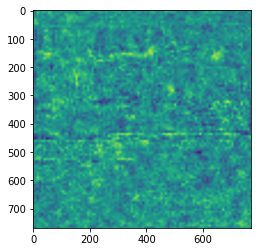

tensor([[ 0.0068, -0.0592, -0.1252,  ..., -0.2720, -0.3359, -0.3997],
        [ 0.0040, -0.0574, -0.1187,  ..., -0.2295, -0.2889, -0.3482],
        [ 0.0011, -0.0556, -0.1123,  ..., -0.1871, -0.2419, -0.2968],
        ...,
        [-0.1209, -0.1421, -0.1634,  ...,  0.0153, -0.0156, -0.0465],
        [-0.1515, -0.1762, -0.2009,  ..., -0.0272, -0.0661, -0.1049],
        [-0.1822, -0.2103, -0.2385,  ..., -0.0697, -0.1165, -0.1634]],
       grad_fn=<SelectBackward0>)


In [ ]:
import matplotlib.pyplot as plt

print(outputs[0].shape)
print(outputs[0][0][2])
out = outputs[0][0][2].detach().numpy()
plt.imshow(out)
plt.show()

# label
y = outputs[0][0][2]
print(y)

## Time metrics

In [ ]:
device = torch.device('cuda')
#torch.backends.cudnn.enabled = True
#torch.backends.cudnn.benchmark = True

model = FastSCNN(9)
model.eval()
model.to(device)
iterations = None

#input = torch.randn(1, 3, 1024, 2048).cuda()
input = torch.randn(1, 3, 256, 512).cuda()
with torch.no_grad():
    for _ in range(10):
        model(input)

    if iterations is None:
        elapsed_time = 0
        iterations = 100
        while elapsed_time < 1:
            torch.cuda.synchronize()
            torch.cuda.synchronize()
            t_start = time.time()
            for _ in range(iterations):
                model(input)
            torch.cuda.synchronize()
            torch.cuda.synchronize()
            elapsed_time = time.time() - t_start
            iterations *= 2
        FPS = iterations / elapsed_time
        iterations = int(FPS * 6)

    print('=========Speed Testing=========')
    torch.cuda.synchronize()
    torch.cuda.synchronize()
    t_start = time.time()
    for _ in range(iterations):
        model(input)
    torch.cuda.synchronize()
    torch.cuda.synchronize()
    elapsed_time = time.time() - t_start
    latency = elapsed_time / iterations * 1000
torch.cuda.empty_cache()
FPS = 1000 / latency
print(FPS)

=========Speed Testing=========
132.75117717414705


In [ ]:
device = torch.device('cuda')
model = FastSCNN(19)
model.eval()
model.to(device)
total=0
for x in range(0,100):
    image = torch.randn(1, 3, 1024, 2048).cuda()
    with torch.no_grad():
        a = time.perf_counter()
        output = model(image)
        torch.cuda.synchronize()
        b = time.perf_counter()
        total+=b-a
print(str(100/total))

20.458430561934293


In [ ]:
!nvidia-smi

Mon Nov 22 03:47:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    59W / 149W |   1458MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------